In [1]:
# 调用相关库
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
from math import sqrt
import random
from numpy import concatenate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import scipy as spy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame
from pandas import concat
import numpy
from scipy.io import savemat,loadmat
import os 
import copy
import math
from scipy.spatial.distance import cdist
from numpy import dot, exp

In [2]:
class DELM(object):

    def __init__(self, input_size,hidden_sizes,output_size,C,TF):
        # 初始化
        '''
            input_size:输入层节点数
            hidden_sizes:各隐含层节点数，也是各elm-ae的隐含层节点数
            output_size:输出层节点数
            C ： L2 正则化系数
            TF： 激活函数
        '''
        self._sizes = hidden_sizes
        self._l2penalty=C
        self.TF=TF 
        self.elmae=[]
        self.w=[]
        
        for i,size in enumerate(self._sizes + [output_size]):
            
            # 采样正交随机数进行网络权重初始化
            
            if input_size>=size:
                IW=spy.linalg.orth(np.random.rand(input_size,size)*2-1)
            else:
                IW=(np.random.rand(input_size,size)*2-1).T
                IW=spy.linalg.orth(IW).T
            # bias
            B=spy.linalg.orth(np.random.rand(size,1)*2-1)
            
            self.w.append(IW)
            
            if i< len(self._sizes + [output_size])-1:
                weight={'w':IW,'b':B}
                self.elmae.append(weight)
            
            input_size = size
    #无监督预训练各个ELM-AE
    def pretrain(self,X):
        self.elm_ae_weigth_list=[]#保存训练好的elmae的输出层权重 ，用于DELM初始化
        nsample=X.shape[0]
        for i in range(len(self.elmae)):
            IW=self.elmae[i]['w']
            B=self.elmae[i]['b']
            
            bias_matrix=np.tile(B,nsample).T
            
            tempH = np.dot(X,IW)+bias_matrix
            
            if self.TF=='sigmoid':
                H = 1. / (1. + np.exp(-tempH))
                
            elif self.TF=='sin':
                H=np.sin(tempH)
            # cal the output weights by least square method
            interval=(np.dot(H.T,H)+np.eye(IW.shape[1])/self._l2penalty)
            beta = np.dot(np.dot(np.linalg.pinv(interval) ,H.T),X)
            
            
            W=np.linalg.pinv(beta)
            # W = beta.T
            self.elm_ae_weigth_list.append(W)
            X=X.dot(W)
#                
    # 将训练好的elm-ae的输出层权重用于初始化delm
    def load_from_elm_aes(self):
        for i in range(len(self._sizes)):
            self.w[i] = self.elm_ae_weigth_list[i]
        
    # Training delm
    def train(self,X,Y):
        self.load_from_elm_aes()#注释掉这句 就不会采用训练好的elm-ae输出层权重对delm进行初始化
        
        
        H=[]
        input_=X
        a=len(self._sizes)
        
        for i in range(a):
            H=np.dot(input_,self.w[i])
            input_=H

        interval=np.dot(H.T,H)+np.eye(H.shape[1])/self._l2penalty
        
        beta = np.dot(np.dot(np.linalg.pinv(interval) ,H.T),Y)
        
        self.w[-1]=beta
        
    def predict(self,teX):
        H=[]
        input_=teX
        a=len(self.w)
        
        for i in range(a):
            H=np.dot(input_,self.w[i])
            input_=H
        return H

In [3]:
'''边界检查函数'''
def boundary(pop,lb,ub):
    pop=pop.flatten()
    lb=lb.flatten()
    ub=ub.flatten()
    
    for i in range(len(lb)):
        if pop[i]>ub[i] or pop[i]<lb[i]:

            pop[i] = (ub[i]-lb[i])*np.random.rand()+lb[i]

    return pop


''' 种群初始化函数 '''
def initial(pop, dim, ub, lb):
    X = np.zeros([pop, dim])
    lb=lb.flatten()
    ub=ub.flatten()
    for i in range(pop):
        for j in range(dim):
            X[i, j] = np.random.rand()*(ub[j] - lb[j]) + lb[j]
    
    return X


'''计算适应度函数'''
def CaculateFitness(X,lb,ub,opts,P,T,Pt,Tt):
    pop = X.shape[0]
    fitness = np.zeros([pop, 1])
    for i in range(pop):
        X[i, :]=boundary(X[i, :],lb,ub)
        fitness[i] = fun(X[i, :],opts,P,T,Pt,Tt)
    return fitness

'''适应度排序'''
def SortFitness(Fit):
    fitness = np.sort(Fit, axis=0)
    index = np.argsort(Fit, axis=0)
    return fitness,index


'''根据适应度对位置进行排序'''
def SortPosition(X,index):
    Xnew = np.zeros(X.shape)
    for i in range(X.shape[0]):
        Xnew[i,:] = X[index[i],:]
    return Xnew

'''Levy'''           
def Levy(d):
     beta = 3/2
     sigma = (math.gamma(1+beta)*np.sin(np.pi*beta/2)/(math.gamma((1+beta)/2)*beta*2**((beta -1)/2)))**(1/beta)
     u = np.random.randn(1,d)*sigma
     v = np.random.randn(1,d)
     step = u/(np.abs(v)**(1/beta))
     L = 0.01*step
     return L 

    
    
'''哈里斯鹰优化算法'''
def HHO(opts,P,T,Pt,Tt):
    MaxIter=100
    pop=20

    c=-1
    d=1
    dim=0
    nodes_num= [opts['input_size']]+opts['hidden_sizes']# 输入层与隐含层的节点数
    
    for i in range(len(nodes_num)-1):
        dim += nodes_num[i]*nodes_num[i+1]+nodes_num[i+1]
    ub=d*np.ones((dim,1))
    lb=c*np.ones((dim,1))
    X= initial(pop, dim, ub, lb) #初始化种群
    fitness = CaculateFitness(X,lb,ub,opts,P,T,Pt,Tt) #计算适应度值
    minIndex = np.argmin(fitness)
    GbestScore = copy.copy(fitness[minIndex])
    GbestPositon = np.zeros([1,dim])
    GbestPositon[0,:] = copy.copy(X[minIndex,:])
    result = np.zeros([MaxIter,dim])
    Curve = np.zeros([MaxIter,1])
    for t in range(MaxIter):
        E1=2*(1-(t/MaxIter))
        for i in range(pop):
            E0=2*np.random.random()-1 #[-1,1]
            Escaping_Energy = E1*E0
            if np.abs(Escaping_Energy)>=1:
                q=np.random.random()
                rand_Hawk_index = int(pop*np.random.random())
                X_rand = np.zeros([1,dim])
                X_rand = copy.copy(X[rand_Hawk_index,:])
                if q<0.5:
                    X[i,:]=X_rand-np.random.random()*np.abs(X_rand-2*np.random.random()*X[i,:])
                else:
                    XMean = np.sum(X,axis=0)/dim
                    X[i,:]=GbestPositon[0,:]-XMean-np.random.random()*((ub.T-lb.T)*np.random.random()+lb.T)
            else:
                r=np.random.random()
                if r>=0.5 and np.abs(Escaping_Energy)<0.5:
                    X[i,:]=GbestPositon-Escaping_Energy*np.abs(GbestPositon-X[i,:])
                if r>=0.5 and np.abs(Escaping_Energy)>=0.5:
                    Jump_strength=2*(1-np.random.random())
                    X[i,:]=(GbestPositon-X[i,:])-Escaping_Energy*np.abs(Jump_strength*GbestPositon-X[i,:])
                if r<0.5 and np.abs(Escaping_Energy)>=0.5:
                    Jump_strength=2*(1-np.random.random())
                    X1=GbestPositon-Escaping_Energy*np.abs(Jump_strength*GbestPositon-X[i,:])
                    X1=boundary(X1,lb,ub)
                    X[i,:]=boundary(X[i,:],lb,ub)
                    if fun(X1,opts,P,T,Pt,Tt)<fun(X[i,:],opts,P,T,Pt,Tt):
                        X[i,:] = copy.copy(X1)
                    else:
                        X2=GbestPositon-Escaping_Energy*np.abs(Jump_strength*GbestPositon-X[i,:])+np.random.random()*Levy(dim)
                        X2=boundary(X2,lb,ub)
                        X[i,:]=boundary(X[i,:],lb,ub)
                        if fun(X2,opts,P,T,Pt,Tt)<fun(X[i,:],opts,P,T,Pt,Tt):
                            X[i,:] = copy.copy(X2)
                if r<0.5 and np.abs(Escaping_Energy)<0.5:
                    Jump_strength=2*(1-np.random.random())
                    XMean = np.sum(X,axis=0)/dim
                    X1=GbestPositon-Escaping_Energy*np.abs(Jump_strength*GbestPositon-XMean)
                    X1=boundary(X1,lb,ub)
                    X[i,:]=boundary(X[i,:],lb,ub)
                    if fun(X1,opts,P,T,Pt,Tt)<fun(X[i,:],opts,P,T,Pt,Tt):
                        X[i,:] = copy.copy(X1)
                    else:
                        X2= GbestPositon-Escaping_Energy*np.abs(Jump_strength*GbestPositon-XMean)+np.random.random()*Levy(dim)
                        X2=boundary(X2,lb,ub)
                        X[i,:]=boundary(X[i,:],lb,ub)
                        if fun(X2,opts,P,T,Pt,Tt)<fun(X[i,:],opts,P,T,Pt,Tt):
                            X[i,:] = copy.copy(X2)
        for ixx in range(pop):X[ixx,:]=boundary(X[ixx,:],lb,ub)
        fitness = CaculateFitness(X,lb,ub,opts,P,T,Pt,Tt) #计算适应度值
        minIndex = np.argmin(fitness)
        if fitness[minIndex]<GbestScore:
            GbestScore = copy.copy(fitness[minIndex])
            GbestPositon[0,:] = copy.copy(X[minIndex,:])
        
        Curve[t] = GbestScore
        result[t,:]=GbestPositon
        print(('第%d次优化,最优适应度值为%0.4f') % (t + 1, GbestScore))
    return GbestPositon,Curve

In [4]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
values=pd.read_csv('train.csv').values[:5000,-1]
values=values.reshape(-1,1)
n_features=1 #特征数量

In [6]:
# 标准化
scaler =StandardScaler()
scaled = scaler.fit_transform(values)

In [7]:
n_in = 3
n_out = 1
# 构造一个20->1的监督学习型数据
reframed = series_to_supervised(scaled, n_in=n_in, n_out=n_out)
values=reframed.values

In [8]:
#训练集和测试集的划分比例
ratio=0.8 
N=int(len(values) *ratio)
train = values[:N, :]
test = values[N:, :]

# 划分输入和输出,split into input and outputs
n_obs = n_in * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3997, 3) (3997,) (1000, 3) (1000,)


In [9]:
train_y=train_y.reshape(-1,1)
train_y.shape

(3997, 1)

In [10]:
def fun(pop,opts,P,T,Pt,Tt):
    #对麻雀传人的参数进行解码
    Net = DELM(opts['input_size'],opts['hidden_sizes'], opts['output_size'], opts['C'],opts['TF']) #construct a delm
    
    nodes= [opts['input_size']]+opts['hidden_sizes']# 输入层与隐含层的节点数

    nelmae=len(nodes)-1
    para_num=[]
    
    for i in range(nelmae):
        if i==0:
            para_num += [nodes[i]*nodes[i+1]]
        else:
            para_num += [para_num[-1]+nodes[i]*nodes[i+1]]
        para_num += [para_num[-1]+nodes[i+1]]
    
    for i in range(nelmae):
        if i==0:
            IW=pop[0:para_num[i]]
            b=pop[para_num[i]:para_num[i+1]]
        else:
            IW=pop[para_num[2*i-1]:para_num[2*i]]
            b=pop[para_num[2*i]:para_num[2*i+1]]
        
        if nodes[i]>=nodes[i+1]:
            Net.elmae[i]['w']=spy.linalg.orth(IW.reshape(nodes[i],nodes[i+1]))
        else:
            Net.elmae[i]['w']=spy.linalg.orth(IW.reshape(nodes[i],nodes[i+1]).T).T
        Net.elmae[i]['b']=spy.linalg.orth(b.reshape(-1,1))


        
    Net.pretrain(P)
    Net.train(P,T)
    output=Net.predict(Pt)
    output1=output.reshape(-1,)
    Tt1=Tt.reshape(-1,)
    fit=np.mean(np.square(output1-Tt1))
    
    return fit

第1次优化,最优适应度值为0.8939
第2次优化,最优适应度值为0.8939
第3次优化,最优适应度值为0.8939
第4次优化,最优适应度值为0.8939
第5次优化,最优适应度值为0.8939
第6次优化,最优适应度值为0.8939
第7次优化,最优适应度值为0.8939
第8次优化,最优适应度值为0.8939
第9次优化,最优适应度值为0.8939
第10次优化,最优适应度值为0.8939
第11次优化,最优适应度值为0.8939
第12次优化,最优适应度值为0.8939
第13次优化,最优适应度值为0.8939
第14次优化,最优适应度值为0.8939
第15次优化,最优适应度值为0.8939
第16次优化,最优适应度值为0.8939
第17次优化,最优适应度值为0.8939
第18次优化,最优适应度值为0.8939
第19次优化,最优适应度值为0.8939
第20次优化,最优适应度值为0.8939
第21次优化,最优适应度值为0.8939
第22次优化,最优适应度值为0.8939
第23次优化,最优适应度值为0.8939
第24次优化,最优适应度值为0.8939
第25次优化,最优适应度值为0.8939
第26次优化,最优适应度值为0.8939
第27次优化,最优适应度值为0.8921
第28次优化,最优适应度值为0.8921
第29次优化,最优适应度值为0.8921
第30次优化,最优适应度值为0.8921
第31次优化,最优适应度值为0.8921
第32次优化,最优适应度值为0.8921
第33次优化,最优适应度值为0.8921
第34次优化,最优适应度值为0.8921
第35次优化,最优适应度值为0.8921
第36次优化,最优适应度值为0.8921
第37次优化,最优适应度值为0.8921
第38次优化,最优适应度值为0.8921
第39次优化,最优适应度值为0.8921
第40次优化,最优适应度值为0.8921
第41次优化,最优适应度值为0.8921
第42次优化,最优适应度值为0.8921
第43次优化,最优适应度值为0.8921
第44次优化,最优适应度值为0.8921
第45次优化,最优适应度值为0.8921
第46次优化,最优适应度值为0.8921
第47次优化,最优适应度值为0.8921
第48次优化,最优适应度值为0.8921
第

Text(0.5, 0, 'iteration')

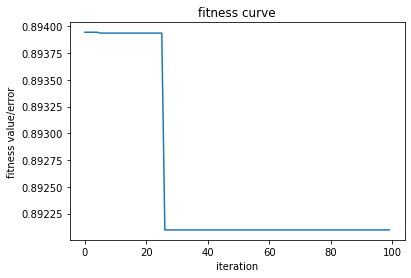

In [11]:
# In[] 参数设置
hidden_sizes = [7,5]  #几个数就是几个隐含层，n个隐含层各自的节点就是[n1;n2;n3;n4;....nn]
input_size = train_X.shape[1] #输入层节点数
output_size= train_y.shape[1]#输出层节点数
C=np.inf#L2正则化系数
TF='sigmoid'#激活函数
opts={'hidden_sizes':hidden_sizes,'input_size':input_size,'output_size':output_size,'C':C,'TF':TF}
pop,trace=HHO(opts,train_X,train_y,test_X, test_y)
plt.figure()
plt.plot(trace)
plt.title('fitness curve')
plt.ylabel('fitness value/error')
plt.xlabel('iteration')

In [12]:
# In[3]: 训练
Net = DELM(input_size,hidden_sizes, output_size, C,TF) #construct a delm

x=pop.flatten().copy()
#对麻雀传人的参数进行解码

nodes= [input_size]+hidden_sizes# 输入层与隐含层的节点数
 
nelmae=len(nodes)-1

para_num=[]

for i in range(nelmae):
    if i==0:
        para_num += [nodes[i]*nodes[i+1]]
    else:
        para_num += [para_num[-1]+nodes[i]*nodes[i+1]]
    para_num += [para_num[-1]+nodes[i+1]]

for i in range(nelmae):
    if i==0:
        IW=x[0:para_num[i]]
        b=x[para_num[i]:para_num[i+1]]
    else:
        IW=x[para_num[2*i-1]:para_num[2*i]]
        b=x[para_num[2*i]:para_num[2*i+1]]
    
    if nodes[i]>=nodes[i+1]:
        Net.elmae[i]['w']=spy.linalg.orth(IW.reshape(nodes[i],nodes[i+1]))
    else:
        Net.elmae[i]['w']=spy.linalg.orth(IW.reshape(nodes[i],nodes[i+1]).T).T
    Net.elmae[i]['b']=spy.linalg.orth(b.reshape(-1,1))

In [13]:
Net.pretrain(train_X)#train elmae
Net.train(train_X,train_y)#train delm

In [14]:
#预测
yhat = Net.predict(test_X)
yhat=yhat.reshape(-1,1)
# 对预测结果进行反归一化
inv_yhat = scaler.inverse_transform(yhat)
# 将真实列据进行反归一化
test_y=test_y.reshape(-1,1)
inv_y = scaler.inverse_transform(test_y)

In [15]:
# 计算RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(inv_y, inv_yhat))
print('Test R2: %.7f' % r2_score(inv_y, inv_yhat))

Test RMSE: 15.5072563
Test MAE: 12.3932167
Test R2: 0.0236045


In [ ]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.figure(figsize=(6,4),dpi=600)
x=range(1, len(inv_y) + 1)
plt.xticks(x[::50])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, inv_y, linestyle="--",color='g',linewidth=1, label='Acture')
plt.plot(x, inv_yhat,  color='red',linestyle="--",linewidth=1,label='HHO-DELM')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("值",fontsize=10)
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
# plt.savefig('台湾VMD-LSTM震级预测结果图.png')
plt.show()

In [ ]:
#保存预测结果
# savemat('hho-delm_result.mat',{'true':inv_y,'pred':inv_yhat})